In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [28]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-03-04 00:03:51,767 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-03-04 00:03:51,781 INFO: Initializing external client
2025-03-04 00:03:51,781 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-04 00:03:52,449 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1215645


In [29]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Error creating feature view: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1215645/featurestores/1203276/featureview). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270179,"usrMsg":"Feature view: time_series_hourly_feature_view, version: 1","errorMsg":"The provided feature view name and version already exists"}', error code: 270179, error msg: The provided feature view name and version already exists, user msg: Feature view: time_series_hourly_feature_view, version: 1
Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [30]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (108.07s) 


In [31]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [32]:
ts_data.head()

,pickup_hour,pickup_location_id,rides
0,2025-02-01 23:00:00+00:00,2,0
1,2025-02-02 00:00:00+00:00,2,0
2,2025-02-02 01:00:00+00:00,2,0
3,2025-02-02 02:00:00+00:00,2,0
4,2025-02-02 03:00:00+00:00,2,0


In [33]:
ts_data["pickup_hour"].min()

'2025-02-01 23:00:00+00:00'

In [34]:
ts_data["pickup_hour"].max()

'2025-03-02 22:00:00+00:00'

In [35]:
ts_data_copy = ts_data.copy()

In [36]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [37]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174696 entries, 0 to 174695
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   pickup_hour         174696 non-null  datetime64[ns, UTC]
 1   pickup_location_id  174696 non-null  int32              
 2   rides               174696 non-null  int32              
dtypes: datetime64[ns, UTC](1), int32(2)
memory usage: 2.7 MB


In [38]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [39]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174696 entries, 0 to 174695
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pickup_hour         174696 non-null  datetime64[ns]
 1   pickup_location_id  174696 non-null  int32         
 2   rides               174696 non-null  int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 2.7 MB


In [40]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [41]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2025-02-01 23:00:00,2,0,2025-02
1,2025-02-02 00:00:00,2,0,2025-02
2,2025-02-02 01:00:00,2,0,2025-02
3,2025-02-02 02:00:00,2,0,2025-02
4,2025-02-02 03:00:00,2,0,2025-02
...,...,...,...,...
174691,2025-03-02 18:00:00,263,114,2025-03
174692,2025-03-02 19:00:00,263,93,2025-03
174693,2025-03-02 20:00:00,263,85,2025-03
174694,2025-03-02 21:00:00,263,67,2025-03


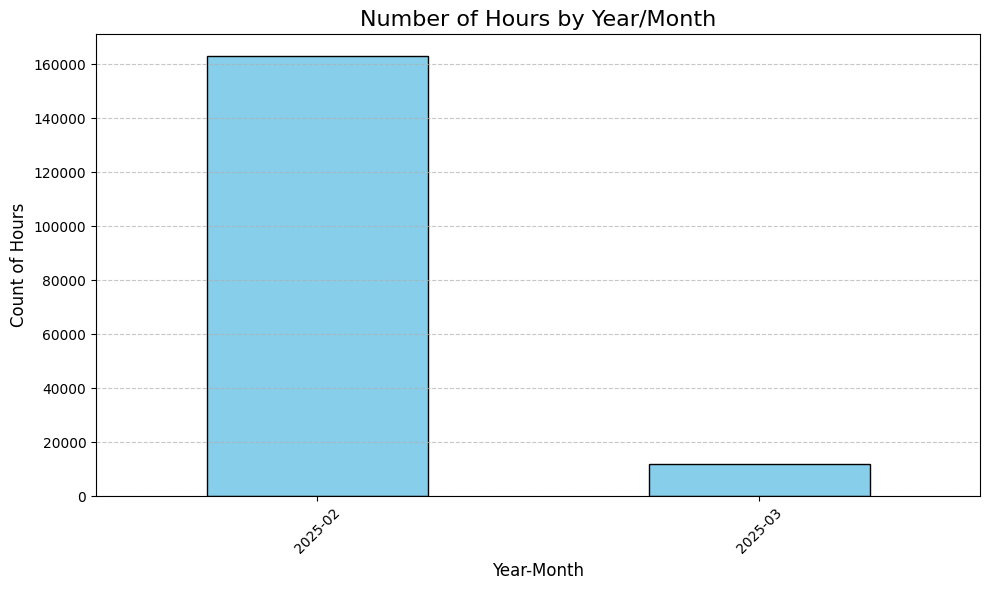

In [42]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [43]:
ts_data.head()      

,pickup_hour,pickup_location_id,rides,year_month
0,2025-02-01 23:00:00,2,0,2025-02
1,2025-02-02 00:00:00,2,0,2025-02
2,2025-02-02 01:00:00,2,0,2025-02
3,2025-02-02 02:00:00,2,0,2025-02
4,2025-02-02 03:00:00,2,0,2025-02


In [44]:
gte = ts_data["year_month"] >= pd.Period("2023-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2023-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [45]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [46]:
filtered_data.shape

(0, 3)

In [47]:
ts_data = filtered_data

In [48]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pickup_hour         0 non-null      datetime64[ns]
 1   pickup_location_id  0 non-null      int32         
 2   rides               0 non-null      int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 124.0 bytes


In [49]:
ts_data.head()["pickup_hour"].values

array([], dtype='datetime64[ns]')

In [50]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

ValueError: No data could be transformed. Check if input DataFrame is empty or window size is too large.

In [ ]:
features.sort_values(["pickup_location_id", "pickup_hour"])

In [ ]:
features[features["pickup_location_id"] == 2]

In [ ]:
features_copy = features.copy()

In [ ]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

In [ ]:
from datetime import datetime, timedelta  
import pandas as pd  
from src.data_utils import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

In [ ]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
X_train.info()

In [ ]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [ ]:
pipeline.fit(features, targets)

In [ ]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [ ]:
predictions

In [ ]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

In [ ]:
import joblib  


# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

In [ ]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [ ]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
    include_files=["src/", "requirements.txt"]  # Include directories and files
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
# model.save(config.MODELS_DIR / 'lgb_model.pkl')
model.save('C:\\Users\\mkhaw\\github\\sp25_taxi\\models\\lgb_model.pkl')

In [ ]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

In [ ]:
from src.inference import get_model_predictions

In [ ]:
preds = get_model_predictions(model, features_copy)

In [ ]:
model.get_m

In [ ]:
preds

In [ ]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")